In [3]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/Shared drives/machine learning"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
hw_clustering_ski.ipynb  hw_test_set.csv  hw_train_set.csv


Feature description: <br />
ambient	: Ambient temperature <br />
coolant : Coolant temperature <br />
u_d : Voltage d-component <br />
u_q	: Voltage q-component
motor_speed : Motor speed <br />
torque : Torque induced by current <br />
i_d : Current d-component <br />
i_q : Current q-component <br />
pm : Permanent Magnet surface temperature <br />
stator_yoke	: Stator yoke temperature <br />
stator_tooth : Stator tooth temperature <br />
stator_winding : Stator winding temperature <br />
profile_id : Distinctive session ID <br />
<br />
The task is to design a model with appropriate feature engineering, that estimates four target temperatures (pm stator_yoke stator_tooth stator_winding) in a causal manner <br />

In [4]:
import requests
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split


train_dataset = '/content/drive/Shared drives/machine learning/hw_train_set.csv'
df_main = pd.read_csv(train_dataset)
df_main.head()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033,4
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631,4
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343,4
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632,4
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145,4


Feature importance and selection

[dtype('int64'), dtype('float64')]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f75694b6f98>,
      dtype=object)

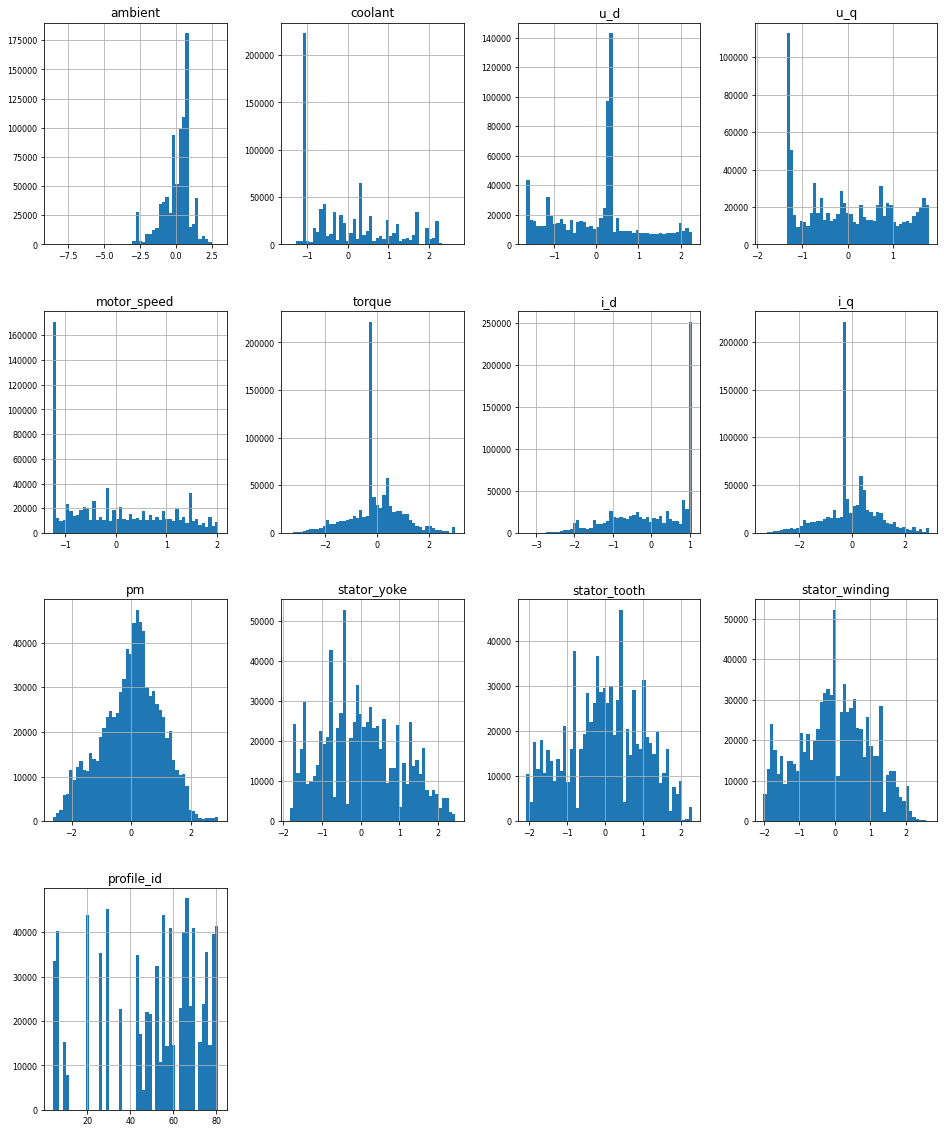

In [4]:
print(list(set(df_main.dtypes.tolist())))
df_num = df_main.select_dtypes(include=['float64', 'int64'])
df_num.hist(figsize=(16,20), bins=50, xlabelsize=8, ylabelsize=8)

In [5]:
X = df_main.drop(columns=['pm', 'stator_yoke', 'stator_tooth', 'stator_winding', 'profile_id'])
#Y_gini_score = df_main['pm']

#x_gini_train, x_gini_test, y_gini_train, y_gini_test = train_test_split(X_gini_score, Y_gini_score, test_size=0.30, random_state=42)

#dtc_classifier =  DecisionTreeClassifier(max_depth=3, criterion='gini', random_state=0)
#dtc_classifier.fit(x_gini_train, y_gini_train)
# See Correlations of other features to pm temprature
target_feature_list = ['pm', 'stator_yoke', 'stator_tooth', 'stator_winding']

for feature in target_feature_list:
  X[feature] = df_main[feature]
  df_num_corr = X.corr()[feature]
  golden_features_list = df_num_corr[abs(df_num_corr) > 0.1].sort_values(ascending=True)
  print("There is {} correlated values with feature {}:\n{}"
        .format(len(golden_features_list), feature, golden_features_list))
  X = X.drop(columns=[feature])

There is 7 correlated values with feature pm:
i_d           -0.291318
i_q           -0.111800
u_q            0.110613
motor_speed    0.334227
coolant        0.451611
ambient        0.558549
pm             1.000000
Name: pm, dtype: float64
There is 8 correlated values with feature stator_yoke:
i_d           -0.183370
i_q           -0.116177
torque        -0.108841
u_q            0.113901
motor_speed    0.193406
ambient        0.465432
coolant        0.882167
stator_yoke    1.000000
Name: stator_yoke, dtype: float64
There is 6 correlated values with feature stator_tooth:
i_d            -0.382091
u_q             0.159463
motor_speed     0.337127
ambient         0.430322
coolant         0.707196
stator_tooth    1.000000
Name: stator_tooth, dtype: float64
There is 7 correlated values with feature stator_winding:
i_d              -0.531083
u_d              -0.127975
u_q               0.138465
ambient           0.344476
motor_speed       0.392176
coolant           0.531963
stator_winding    1

Where we can see <br />
Coolant motor_speed ambient i_d are most important features correlated to target features, profile_id is least correlated

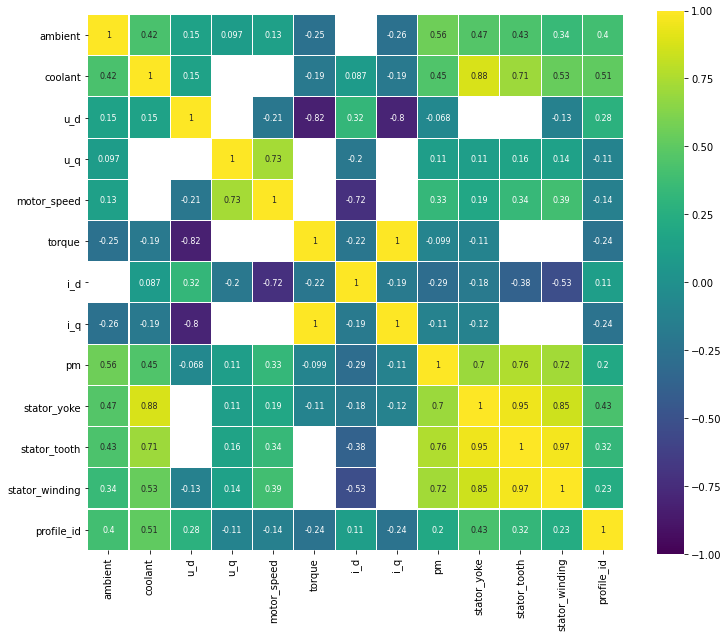

In [6]:
# Features correlations
#
# We already examined AcresBurned correlations
# We use heatmap to better understand correlations among features
# Shown with the abslute correlation > 0.06
corr = df_main.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr[(corr >= 0.06) | (corr <= -0.06)],
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

Use elbow method to determine cluster number N <br />

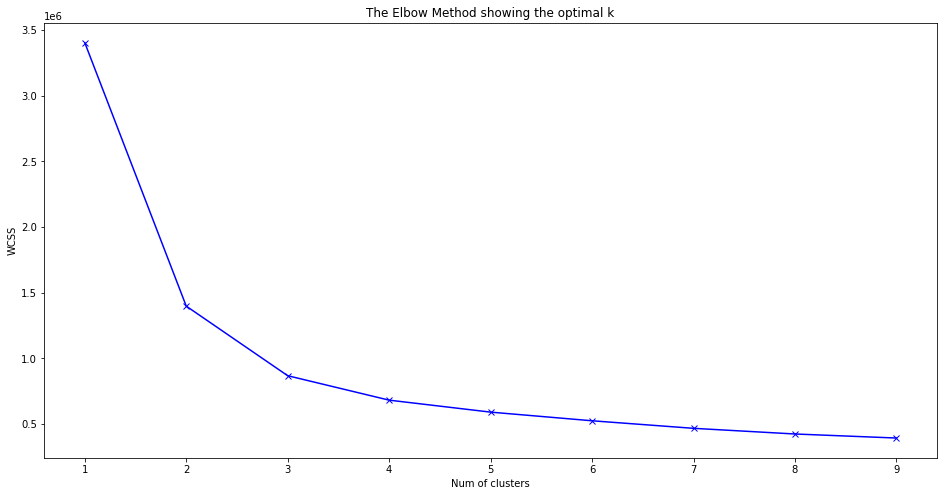

In [7]:
from sklearn.cluster import KMeans

df_cluster = df_main[target_feature_list]
wcss = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeanModel.fit(df_cluster)
    wcss.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, wcss, 'bx-')
plt.xlabel('Num of clusters')
plt.ylabel('WCSS')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Use KMean clustering, N=3

In [8]:
n_clusters = 3
X = df_cluster.to_numpy()
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)


Clusters visualization

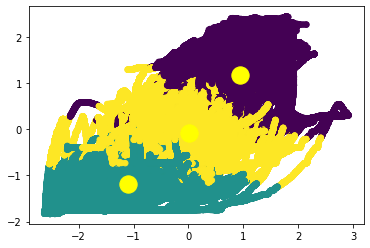

In [99]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=30, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='yellow', label = 'Centroids')
plt.show()

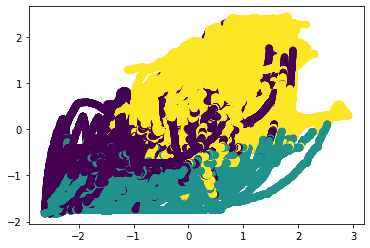

In [10]:
from sklearn import mixture

gmm = mixture.GaussianMixture(n_components=3).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis')

In [100]:
df_main['y_kmean'] = kmeans.labels_
df_main['y_gmm'] = labels
df_main.sample(n=20)

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id,y_kmean,y_gmm
590647,0.680160,1.577152,2.202856,-0.596578,0.535581,-1.896644,-1.649143,-1.728492,0.645266,1.571783,1.534617,1.508695,66,0,1
526306,0.296284,0.351011,1.447259,1.170898,0.714066,-0.967139,-0.139424,-0.961539,-0.080345,0.400127,0.395466,0.401244,65,2,1
238734,-2.749857,-1.073309,0.196796,0.077939,-0.573118,-0.119456,1.013963,-0.091436,-1.674869,-1.596202,-1.754839,-1.780783,36,1,2
772502,0.492924,1.176665,1.966303,0.318464,0.481141,-1.530602,-0.638646,-1.482836,0.909917,1.327251,1.228947,1.007998,79,0,1
152433,-0.933065,-1.034926,-1.612742,-0.685294,0.806668,1.021899,-2.032795,0.851745,-0.357935,-0.055353,0.599747,1.217677,27,2,0
835931,-0.151192,1.747555,1.969896,0.391080,0.072498,-1.820294,0.020871,-1.898469,0.655665,1.628618,1.381973,1.139270,72,0,1
291409,-0.850885,1.096828,0.308055,-0.731708,-0.951864,-0.255640,1.029117,-0.245712,0.242436,0.613628,0.155906,-0.176136,45,2,1
332276,0.616196,0.339771,-0.528965,-0.663562,-0.779022,2.134380,-0.714164,2.182385,0.675225,1.293103,1.678401,2.017638,49,0,0
700146,-0.695509,-0.821763,-1.518871,-0.313080,0.419693,1.256511,-1.679150,1.101626,-2.001787,-0.871757,-0.762521,-0.416521,75,1,0
605263,0.532414,-0.650552,0.535826,1.341087,0.118444,-0.425970,0.994597,-0.444552,0.028968,-0.396694,0.009722,0.201800,67,2,1


In [ ]:
from sklearn.cluster import SpectralClustering

spc_cluster = SpectralClustering(n_clusters=3,
         assign_labels="discretize",
         random_state=0)
spc_cluster.fit(X)
#y_agg = agg.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=agg.labels_, s=30, cmap='viridis')
plt.show()